In [1]:

pip install tpot

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install auto-sklearn

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn import model_selection
import seaborn as sns
import random
from sklearn.model_selection import KFold

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tpot import TPOTRegressor
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error

In [2]:
def show_correlation_coefficient(data_df,method):
    sns.set(font_scale=1)
    df_corr = data_df.corr(method=method, min_periods=1)
    plt.figure(figsize=(18,14))
    sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot=True,
            linewidths=0.5)

In [3]:
def show_distribution_diagram(data, name):
    sns.set(font_scale=1)
    variable = data[name].fillna(data.mean())
    sns.displot(data=variable, kind="kde", multiple="stack")
    plt.show()

In [4]:
class YieldStressPredict:
    def __init__(self,tpot,auto_sklearn=None):
        self.tpot = tpot
        self.auto_sklearn = auto_sklearn
        

    def fit(self, X_train, y_train):
        self.tpot = self.tpot.fit(X_train,y_train)
        self.auto_sklearn = self.auto_sklearn.fit(X_train,y_train)
        self.X_train = X_train
        self.y_train = y_train
        

    def get_best_pipeline(self,name):
        self.tpot.export("tpot_export"+name+".py")
        result = self.auto_sklearn.cv_results_
        df = pd.DataFrame(result)
        df.to_csv("autosklearn" + name + ".csv")
        

    def predict(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.tpot_predict = self.tpot.predict(X_test)
        self.auto_sklearn_predict = self.auto_sklearn.predict(X_test)

    def mean_squared_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict

        mse = mean_squared_error(self.y_test, y_predict)
        return mse
    def mean_absolute_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        mae = mean_absolute_error(self.y_test,y_predict)
        return  mae
    def r2_score(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        r2 = r2_score(self.y_test, y_predict)
        return r2
    
    def show_deviance_diagrams(self,model_name):
        test_score = np.zeros((self.params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(self.reg.staged_predict(self.X_test)):
            test_score[i] = self.reg.loss_(self.y_test, y_pred)

        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title("Deviance of: " + model_name)
        plt.plot(
            np.arange(self.params["n_estimators"]) + 1, self.reg.train_score_, "b-", label="Training Set Deviance", )
        plt.plot(np.arange(self.params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
        plt.legend(loc="upper right")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance")
        fig.tight_layout()
        plt.show()

    def show_tpot_features_importance(self,model_name):
        feature_names = self.X_train.columns
        best_model = self.tpot.fitted_pipeline_.steps[-1][1]
        best_model.fit(self.X_train,self.y_train)
        feature_importance = best_model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (MDI) of: " + model_name)

        result = permutation_importance(
            self.reg, self.X_test, self.y_test, n_repeats=10, random_state=13, n_jobs=2
        )
        sorted_idx = result.importances_mean.argsort()
        plt.subplot(1, 2, 2)
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(feature_names)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        fig.tight_layout()
        plt.show()


def train_test_split(data_df, target_feature_name, test_size, random_state):
    X = data_df.drop([target_feature_name], axis=1)
    y = data_df[target_feature_name]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_train, X_test, y_train, y_test)




	
    

In [5]:
def compare_frameworks(ys_prediction, data_df, target_feature, test_size, number_of_iterations,file_stats_name):
    header = "Times,random_state,MAE,MSE,R2,type\n"
    filename = file_stats_name
    with open(filename,'w') as f:
        f.write(header)
    for i in range(number_of_iterations):
        random_state = random.randint(1,12341251)
        X_train, X_test, y_train, y_test = train_test_split(data_df, target_feature, test_size, random_state)

        # traings model
        ys_prediction.fit(X_train, y_train)
        # predict test data
        ys_prediction.predict(X_test, y_test)

        mae = ys_prediction.mean_absolute_error(name='tpot')
        mse = ys_prediction.mean_squared_error(name='tpot')
        r2 = ys_prediction.r2_score(name='tpot')
        ys_prediction.get_best_pipeline(str(i))
        newline1 = "{},{},{},{},{},{}\n".format(i,random_state,mae, mse, r2,'tpot')
        mae = ys_prediction.mean_absolute_error(name='auto_sklearn')
        mse = ys_prediction.mean_squared_error(name='auto_sklearn')
        r2 = ys_prediction.r2_score(name='auto_sklearn')
        newline2 = "{},{},{},{},{},{}\n".format(i,random_state,mae, mse, r2,'auto_sklearn')

        with open(filename, 'a') as f:
            f.write(newline1)
            f.write(newline2)
    return ys_prediction
            

In [6]:
filename = "YieldStress_database.csv"
file_stats_name = "framework_stats.csv"
target_feature = "YS (MPa)"
data_df = pd.read_csv(filename)
data_df = data_df.iloc[:, 1:]



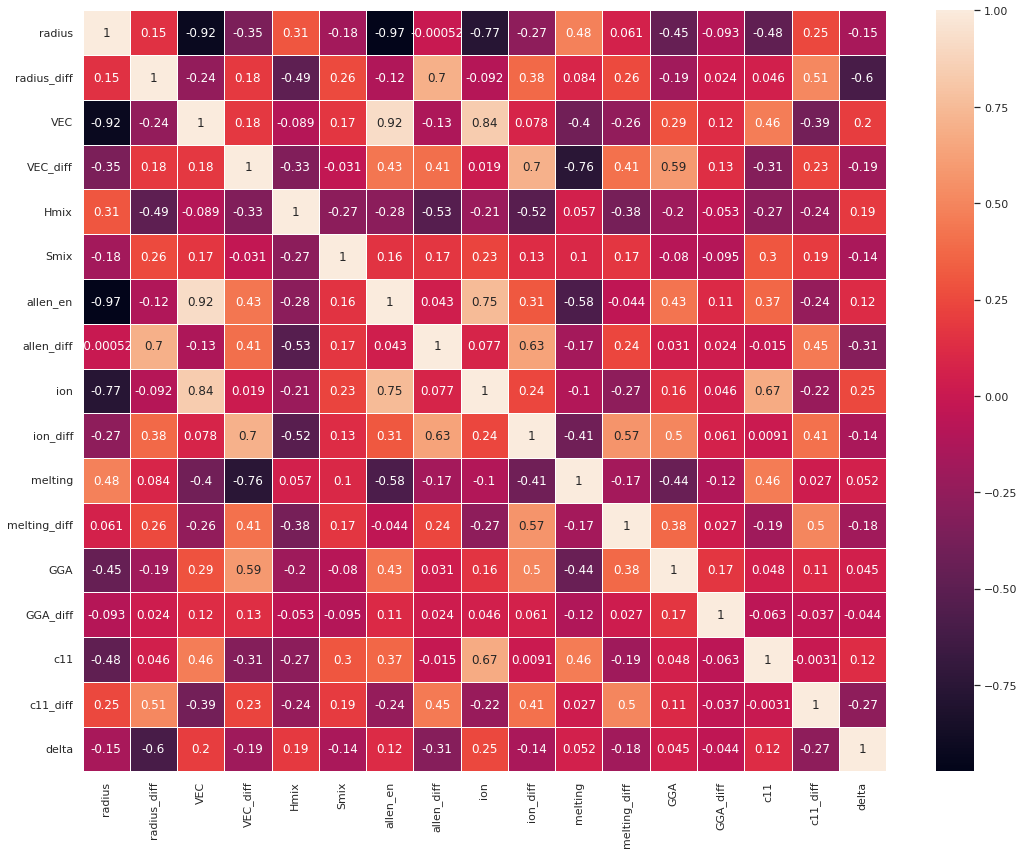

In [7]:
show_correlation_coefficient(data_df=data_df.drop([target_feature],axis = 1),method = "pearson")

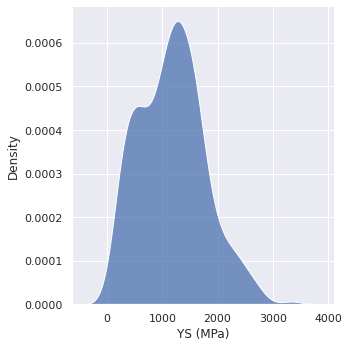

In [8]:
show_distribution_diagram(data_df,target_feature)

In [9]:
cv = KFold(n_splits=5)
tpot_params = {
    "scoring": 'neg_mean_absolute_error',
    "cv": cv,
    "random_state": 1331,
    "verbosity": 3,
    "n_jobs": -1,
    "generations": 30,
    "population_size": 10,
    "max_eval_time_mins": 3
}

auto_sklearn_params = {
    "scoring_functions": [mean_absolute_error],
    "per_run_time_limit": 180,
    "seed": 1331,
    "resampling_strategy_arguments": {'cv': {'folds': 5}},
    "max_models_on_disc":10,
    "n_jobs": -1,
}
tpot = TPOTRegressor(**tpot_params)
auto_sklearn = AutoSklearnRegressor(**auto_sklearn_params)
yield_stress_predict = YieldStressPredict(tpot, auto_sklearn)


In [14]:
compare_frameworks(yield_stress_predict, data_df, target_feature, 0.2, 10)

                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True, False,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [23]:
from matplotlib.ticker import FuncFormatter

def show_diagram_two_model(filename,number_point,aspect,height):
    result = pd.read_csv(filename)
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    new_result = result
    new_result['MAE'] *= -1
    new_result = new_result.drop([result.columns[2],result.columns[3],result.columns[4]],axis = 1)
    for i in range(2, 5):
        property_name = result.columns[i]
        data = result[property_name]
        df = new_result
        df[property_name] = data
        g = sns.catplot(data=df, kind="point", x='Time', y=property_name, hue='Type', ci=None, palette="dark", aspect=aspect, height=aspect)
        ax = g.fig.gca()
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    
    

In [24]:
show_diagram_two_model(file_stats_name,100,3,5)

In [ ]:
dt = {}
y_test = yield_stress_predict.y_test
dt['y_test'] = yield_stress_predict.y_test
dt['tpot_predict'] = yield_stress_predict.tpot_predict
dt['auto_sklearn_predict'] = yield_stress_predict.auto_sklearn_predict
dt['tpot_error'] = [(abs(e1-e2)/e1)  for (e1, e2) in zip(y_test, yield_stress_predict.tpot_predict)]
dt['auto_sklearn_error'] = [(abs(e1-e2)/e1)  for (e1, e2) in zip(y_test, yield_stress_predict.auto_sklearn_predict)]
print(dt)
dt = pd.DataFrame(dt)

dt.to_csv("y_predict.csv")